# tf.data.Dataset简介

* tf.data的核心是tf.data.Dataset类，提供了对数据集的高层封装。
* tf.data.Dataset由一系列的可迭代访问的元素(element)组成,每个元素包含一个或多个张量。Dataset可以看作是相同类型“元素”的有序列表。

# tf.data.Dataset创建数据集

tf.data.Dataset 类创建数据集，对数据集实例化。最常用的有：
* tf.data.Dataset.from_tensors(): 创建Dataset对象，合并输入并返回具有单个元素的数据集
* tf.data.Dataset.from_tensor_slices(): 创建一个Dataset对象，输入可以是一个或者多个tensor，若是多个tensor，需要以元组或者字典等形式组装起来。
* tf.data.Dataset.from_generator(): 迭代生成所需的数据集，一般数据量较大时使用。

### from_tensors和from_tensor_slices区别

from_tensors() 函数会把传入的tensor当做一个元素，但是from_tensor_slices() 会把出入的tensor **除开第0维之后的大小**当做元素个数

# tf.data.Dataset数据集处理

tf.data.Dataset 类为我们提供了多种数据集预处理方法。最常用的如：
* tf.data.Dataset.map(f): 对数据集中的每个元素应用函数f，得到一个新的数据集 （这部分往往结合tf.io进行读写和解码文件，tf.image进行图像处理）；
* tf.data.Dataset.shuffle(buffer_size):将数据集打乱（设定一个固定大小的缓冲区（buffer），取出前buffer_size个元素放入，并从缓冲区中随机采样，采样后的数据用后续数据替换）；
* tf.data.Dataset.batch(batch_size):将数据集分成批次，即对每batch_size个元素，使用tf.stack()在第0维合并，成为一个元素

## TFRecordDataset类

对于特别巨大而无法完整载入内存的数据集，我们可以先将数据集处理为**TFRecord**格式，然后使用tf.data.TFRecordDataset()进行载入。


TFRecord是TensorFlow中的数据集存储格式。

# tf.data.TextLineDataset简介

**tf.data.TextLineDataset**提供了一种从一个或多个文本文件中提取行的简单方法

# 案例分析

## DataSet类读取numpy数据

最基础的建立tf.data.Dataset的方法是使用tf.data.Dataset.from_tensor_slices(),适用于数据量小（能够整个装进内存）的情况。

In [2]:
import numpy as np
import tensorflow as tf
mnist = np.load("mnist.npz")
x_train, y_train = mnist['x_train'], mnist['y_train']

In [7]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [8]:
x_train = np.expand_dims(x_train, axis=-1)

In [9]:
mnist_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

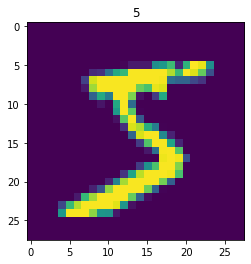

In [11]:
import matplotlib.pyplot as plt
for image, label in mnist_dataset:
    plt.title(label.numpy())
    plt.imshow(image.numpy()[:, :, 0])
    plt.show()
    break

# Pandas数据读取

In [ ]:
import pandas as pd
df = pd.read_csv('heart.csv')

In [ ]:
df['thal'] = pd.Categorical(df['thal'])
df['thal'] = df.thal.cat.codes

In [ ]:
target = df.pop('target')

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

In [ ]:
for feat, targ in dataset.take(5):
    print ('Features: {}, Target: {}'.format(feat, targ))

## 从Python generator构建数据管道

In [14]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [15]:
flowers = './flower_photos/flower_photos/'

In [16]:
def Gen():
    gen = img_gen.flow_from_directory(flowers)
    for (x, y) in gen:
        yield (x, y)

In [17]:
ds = tf.data.Dataset.from_generator(
    Gen,
    output_types=(tf.float32, tf.float32)
)

In [ ]:
for image, label in ds:
    print(image.shape, label.shape)
    break

## TFRecordDataset类

In [ ]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_example(example_string):
    feature_dict = tf.io.parse_single_example(example_string, feature_description)
    feature_dict['image'] = tf.io.decode_jpeg(feature_dict['image'])
    feature_dict['image'] = tf.image.resize(feature_dice['image'], [256, 256]) / 255.0
    return feature_dict['image'], feature_dict['label']

batch_size = 32

train_dataset = tf.data.TFRecordDataset("sub_train.tfrecords")
train_dataset = train_dataset.map(_parse_example)

In [ ]:
for line in train_dataset:
    print(line)
    break

## TextLineDataset类

In [20]:
titanic_lines = tf.data.TextLineDataset(['train.csv', 'eval.csv'])

In [21]:
def data_func(line):
    line = tf.strings.split(line, sep = ",")
    return line

In [22]:
titanic_data = titanic_lines.skip(1).map(data_func)

# Dataset API 高级用法

Dataset的数据转换：
* map(f): (往往结合tf.io进行读写和解码文件，tf.image进行图像处理）
* shuffle(buffer_size):
* repeat(count): 数据重复次数
* batch(batch_size): 使用tf.stack()在第0维合并，成为一个元素

* flat_map(): 将map函数映射到数据集的每一个元素，并将嵌套的Dataset压平。
* interleave(): 效果类似flat_map,但可以将不同来源的数据夹在一起。
* take(): 截取数据集中的前若干个元素

* filter
* zip
* concatenate
* reduce

## 提升Dataset读取性能

模型训练的耗时主要来自于两个部分，**数据准备**，**参数迭代**

参数迭代耗时通常依赖于GPU来提升，而数据准备耗时则可以通过构建高效的数据管道进行tisheng

构建高效管道：
* 使用prefetch方法让数据准备和参数迭代两个过程相互并行

    注意：要预取的元素数量应等于(或可能大于)单个训练步骤消耗的batch数量。可以手动调整此值，也可以将其设置为tf.data.experimental.AUTOTUNE动态调整
* 使用interleave方法可以让数据读取过程多进程执行，并将不同来源数据夹在一起。
* 使用map时设置num_paralled_call让数据转换过程多进程执行
* 使用cache方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形

# 案例讲解

In [1]:
import tensorflow as tf
import time
import os
print(tf.__version__)

2.2.0


In [2]:
data_dir = './data'
train_cats_dir = data_dir + '/train/cats/'
train_dogs_dir = data_dir + '/train/dogs/'
test_cats_dir = data_dir + '/valid/cats/'
test_dogs_dir = data_dir + '/valid/dogs/'

In [3]:
train_cat_filenames = tf.constant([train_cats_dir + filename for filename in os.listdir(train_cats_dir)][:1000])
train_dog_filenames = tf.constant([train_dogs_dir + filename for filename in os.listdir(train_dogs_dir)][:1000])
train_filenames = tf.concat([train_cat_filenames, train_dog_filenames], axis=-1)
train_labels = tf.concat([
    tf.zeros(train_cat_filenames.shape, dtype=tf.int32),
    tf.ones(train_dog_filenames.shape, dtype=tf.int32)
], axis=-1)

In [5]:
def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    image_resized = tf.image.resize(image_decoded, [256, 256]) / 255.0
    return image_resized, label
    
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))

def benchmark(dataset, num_epochs=1):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            time.sleep(0.01)
    tf.print("Execution time:", time.perf_counter() - start_time)

### prefetch 方法

In [ ]:
benchmark(train_dataset.map(
    map_func=_decode_and_resize,
    num_parallel_calls=tf.data.experimental.AUTOTUNE),
num_epochs=1)

In [ ]:
benchmark(train_dataset.map(
    map_func=_decode_and_resize,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)
          .prefetch(tf.data.experimental.AUTOTUNE),
         num_epochs=1
)

### interleave 方法

In [ ]:
# fake data
filenames = ["./interleave_data/train.csv", "./interleve_data/eval.csv",
            "./interleave_data/train.csv", "./interleave_data/eval.csv"]
dataset = tf.data.Dataset.from_tensor_slices(filenames)

def data_func(line):
    line = tf.strings.split(line, sep = ",")
    return line

dataset_1 = dataset.interleave(lambda x:
        tf.data.TextLineDataset(x).skip(1).map(data_func),
        cycle_length=4, block_length=16)

In [ ]:
for line in dataset_1.take(2):
    print(line)

In [ ]:
benchmark(dataset_1,
         num_epochs=1)

In [ ]:
dataset_2 = dataset.interleave(lambda x:
        tf.data.TextLineDataset(x).skip(1).map(data_func),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
        cycle_length=4, block_length=16)

In [ ]:
benchmark(dataset_2,
         num_epochs=1)

### map 方法

In [6]:
benchmark(
    train_dataset.map(
    map_func=_decode_and_resize,
    num_parallel_calls=tf.data.experimental.AUTOTUNE))

Execution time: 23.305241353999996


In [7]:
benchmark(
    train_dataset.map(
    map_func=_decode_and_resize
    )
)

Execution time: 29.035650051000005


### cache 方法

In [8]:
benchmark(
    train_dataset.map(
    map_func=_decode_and_resize,
    num_parallel_calls=tf.data.experimental.AUTOTUNE),
    num_epochs=3)

Execution time: 68.35281913800009


In [9]:
benchmark(
    train_dataset.map(
    map_func=_decode_and_resize,
    num_parallel_calls=tf.data.experimental.AUTOTUNE).cache(),
    num_epochs=3)

Execution time: 67.87963867800045


# 实战二：Cats vs. Dogs

In [10]:
train_cat_filenames = tf.constant([train_cats_dir + filename for filename in os.listdir(train_cats_dir)])
train_dog_filenames = tf.constant([train_dogs_dir + filename for filename in os.listdir(train_dogs_dir)])
train_filenames = tf.concat([train_cat_filenames, train_dog_filenames], axis=-1)
train_labels = tf.concat([
    tf.zeros(train_cat_filenames.shape, dtype=tf.int32),
    tf.ones(train_dog_filenames.shape, dtype=tf.int32)
], axis=-1)

In [11]:
train_filenames

<tf.Tensor: shape=(22778,), dtype=string, numpy=
array([b'./data/train/cats/cat.5077.jpg',
       b'./data/train/cats/cat.2718.jpg',
       b'./data/train/cats/cat.10151.jpg', ...,
       b'./data/train/dogs/dog.6025.jpg',
       b'./data/train/dogs/dog.1992.jpg',
       b'./data/train/dogs/dog.12412.jpg'], dtype=object)>

In [13]:
def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    image_resized = tf.image.resize(image_decoded, [256, 256]) / 255.0
    return image_resized, label
    
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
train_dataset = train_dataset.map(
    map_func=_decode_and_resize,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.shuffle(buffer_size=23000)

train_dataset = train_dataset.repeat(count=3)

train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
img, label = _decode_and_resize(tf.constant('./data/train/cats/cat.5077.jpg'), tf.constant(0))

In [17]:
import matplotlib.pyplot as plt

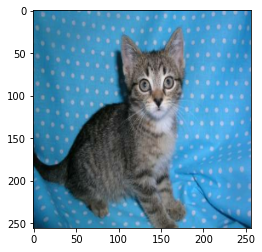

In [19]:
plt.imshow(img.numpy())

In [20]:
test_cat_filenames = tf.constant([test_cats_dir + filename for filename in os.listdir(test_cats_dir)])
test_dog_filenames = tf.constant([test_dogs_dir + filename for filename in os.listdir(test_dogs_dir)])
test_filenames = tf.concat([test_cat_filenames, test_dog_filenames], axis=-1)
test_labels = tf.concat([
    tf.zeros(test_cat_filenames.shape, dtype=tf.int32),
    tf.ones(test_dog_filenames.shape, dtype=tf.int32)
], axis=-1)

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
test_dataset = test_dataset.map(_decode_and_resize)
test_dataset = test_dataset.batch(batch_size)

In [22]:
class CNNModel(tf.keras.models.Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.maxpool1 = tf.keras.layers.MaxPooling2D()
        self.conv2 = tf.keras.layers.Conv2D(32, 5, activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(64, activation='relu')
        self.d2 = tf.keras.layers.Dense(2, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x
    
# softmax CategoricalCrossentropy
# sigmoid tf.keras.losses.BinaryCrossentropy

In [23]:
learning_rate = 0.001
model = CNNModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
# Label 没有one-hot

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)
    
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    test_loss(loss)
    test_accuracy(labels, predictions)

In [24]:
EPOCHS=10
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_dataset:
        train_step(images, labels)
    
    for test_images, test_labels in test_dataset:
        test_step(test_images, test_labels)
        
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                         train_loss.result(),
                         train_accuracy.result() * 100,
                         test_loss.result(),
                         test_accuracy.result() * 100))

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x135d29cb0>
Traceback (most recent call last):
  File "/Users/fatu/venv/tensorflow2py37/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 538, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/Users/fatu/venv/tensorflow2py37/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: 

# TFRecord

**TFRecord** 是一种二进制文件，其能更好的利用内存，其内部包含了多个**tf.train.Example**, 而Example是protocol buffer数据标准的实现，在一个Example消息体中包含了一系列的**tf.train.feature**属性,而每一个feature是一个key-value的键值对，其中，key是string类型，而value的取值有三种：
* bytes_list: 可以存储string和byte两种数据类型
* float_list: 可以存储float(float32)与double(float64)两种数据类型
* int64_list: 可以存储:bool,enum,int32,unit32,int64,unit64.

## 生成TFRecord格式数据
为了将形式各样的数据集整理为TFRecord格式，我们可以对数据集中的每个元素进行以下步骤：
* 读取改数据元素到内存；
* 建立Feature的字典；
* 将该元素转换为tf.train.Example对象（每一个tf.train.Example由若干个tf.train.Feature的字典组成）；
* 将该tf.train.Example对象序列化为字符串，并通过一个预先定义的tf.io.TFRecordWriter写入TFRecord文件

## 读取TFRecord文件步骤
* 通过tf.data.TFRecordDataset读入原始的TFRecord文件（此时文件中的tf.train.Example对象尚未被反序列化），获得一个tf.data.Dataset数据集对象；
* 定义Feature结构，告诉解码器每个Feature的类型是什么；
* 通过Dataset.map方法，对该数据集对象中的每一个序列化的tf.trainExample字符串执行tf.io.parse_single_example函数，从而实现反序列化

## 案例

In [1]:
data_dir = './data'
train_cats_dir = data_dir + '/train/cats/'
train_dogs_dir = data_dir + '/train/dogs/'

train_tfrecord_file = data_dir + '/train/train.tfrecords'

test_cats_dir = data_dir + '/valid/cats/'
test_dogs_dir = data_dir + '/valid/dogs/'
test_tfrecord_file = data_dir + '/valid/test.tfrecords'

### 将数据集存储为TFRecord文件

In [30]:
train_cat_filenames = [train_cats_dir + filename for filename in os.listdir(train_cats_dir)]
train_dog_filenames = [train_dogs_dir + filename for filename in os.listdir(train_dogs_dir)]
train_filenames = train_cat_filenames + train_dog_filenames

train_labels = [0] * len(train_cat_filenames) + [1] * len(train_dog_filenames)

In [32]:
with tf.io.TFRecordWriter(train_tfrecord_file) as writer:
    for filename, label in zip(train_filenames, train_labels):
        image = open(filename, 'rb').read()
        
        feature = {
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
        }
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example.SerializeToString())

## 读取TFRecord文件

In [8]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_example(example_string):
    feature_dict = tf.io.parse_single_example(example_string, feature_description)
    feature_dict['image'] = tf.io.decode_jpeg(feature_dict['image'])
    feature_dict['image'] = tf.image.resize(feature_dict['image'], [256, 256]) / 255.0
    return feature_dict['image'], feature_dict['label']

batch_size = 32

train_dataset = tf.data.TFRecordDataset(train_tfrecord_file)
train_dataset = train_dataset.map(_parse_example)

In [9]:
for image,label in train_dataset.take(1):
    print(image.shape, label.shape)

(256, 256, 3) ()


In [12]:
train_dataset = train_dataset.shuffle(buffer_size=23000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)